In [1]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 

from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import torch
# Folium setup.
import folium

In [2]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/npy/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

4it [00:00, 17.28it/s]


Now all merge samples are saved!


In [3]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)

(17040, 1, 2)
(4261, 1, 2)


In [4]:

number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  9,9,30), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)



In [5]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]

X_val= np.zeros((number_samples,  9,9,30), dtype=float)
for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)

In [6]:
number_samples = X_train.shape[0]
X_train_rf = np.reshape(X_train, (number_samples, 9 * 9 * 30))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)

Post-processed S2_train data shape:  (17040, 2430)


In [7]:
number_samples_v = X_val.shape[0]
X_val_rf = np.reshape(X_val, (number_samples_v, 9 * 9 * 30))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (4261, 2430)


In [8]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [9]:
y_pred_rf = rf_classifier.predict(X_val_rf)

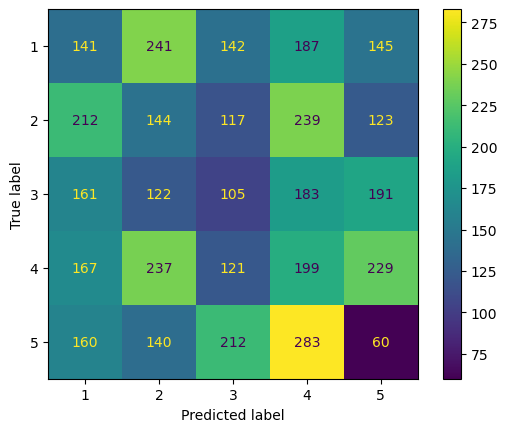

Accuracy Random Forest Classifier:  0.15231166392865525


In [10]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

In [11]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(9,9,30)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-08 02:05:44.663516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-08 02:05:44.664191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
history = simple_model.fit(X_train, Y_train, epochs=10,validation_data=(X_val, Y_val))

Epoch 1/10


2023-01-08 02:05:47.652131: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-08 02:05:47.828962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


529/533 [============================>.] - ETA: 0s - loss: 0.4257 - accuracy: 0.1933

2023-01-08 02:05:51.223371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


533/533 [==============================] - 4s 7ms/step - loss: 0.4257 - accuracy: 0.1933 - val_loss: 0.4282 - val_accuracy: 0.2009
Epoch 2/10
533/533 [==============================] - 3s 7ms/step - loss: 0.4198 - accuracy: 0.1986 - val_loss: 0.4233 - val_accuracy: 0.2009
Epoch 3/10
533/533 [==============================] - 3s 7ms/step - loss: 0.4157 - accuracy: 0.1977 - val_loss: 0.4201 - val_accuracy: 0.2009
Epoch 4/10
533/533 [==============================] - 3s 6ms/step - loss: 0.4125 - accuracy: 0.1986 - val_loss: 0.4173 - val_accuracy: 0.2009
Epoch 5/10
533/533 [==============================] - 3s 6ms/step - loss: 0.4097 - accuracy: 0.1986 - val_loss: 0.4145 - val_accuracy: 0.2009
Epoch 6/10
533/533 [==============================] - 3s 6ms/step - loss: 0.4074 - accuracy: 0.1986 - val_loss: 0.4116 - val_accuracy: 0.2009
Epoch 7/10
533/533 [==============================] - 4s 7ms/step - loss: 0.4046 - accuracy: 0.1986 - val_loss: 0.4094 - val_accuracy: 0.2009
Epoch 8/10
533/53

In [13]:
y_pred_dl_p = simple_model.predict(X_val)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

 58/134 [===========>..................] - ETA: 0s

2023-01-08 02:06:25.644698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 0s 3ms/step
Prediction example:  [0.2750941  0.36532924 0.35957664]  Class:  1


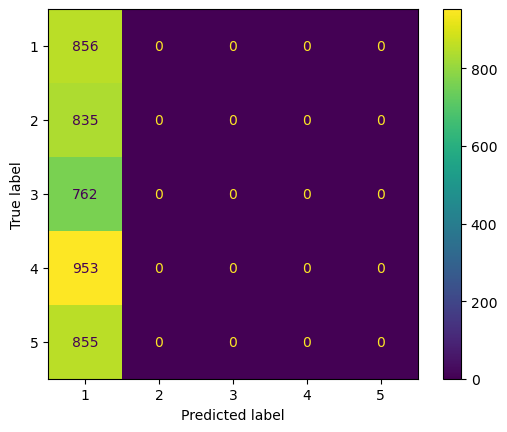

Accuracy Simple Deep Learning model:  0.20089180943440507


In [14]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

134/134 - 1s - loss: 0.4027 - accuracy: 0.2009 - 570ms/epoch - 4ms/step
0.20089180767536163


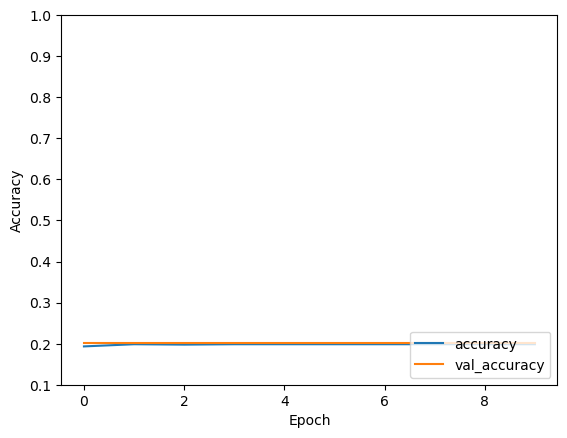

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = simple_model.evaluate(X_val,  Y_val, verbose=2)

print(test_acc)

In [18]:
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(9, (3,3), padding='same', activation="relu",input_shape=(9, 9, 30)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(9, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5)
]
)

In [19]:

model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 9, 9, 9)           2439      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 9)          0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 9)           738       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 9)          0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 36)                0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [20]:

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))

In [21]:

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 9, 9, 9)           2439      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 9)          0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 9)           738       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 9)          0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 36)                0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [22]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, 
                    validation_data=(X_val, Y_val))
     

Epoch 1/10


2023-01-08 02:06:59.535662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


533/533 [==============================] - ETA: 0s - loss: 5.3359 - accuracy: 0.1984

2023-01-08 02:07:04.976912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


533/533 [==============================] - 6s 11ms/step - loss: 5.3359 - accuracy: 0.1984 - val_loss: 46.9789 - val_accuracy: 0.2009
Epoch 2/10
533/533 [==============================] - 5s 10ms/step - loss: 166.4746 - accuracy: 0.2031 - val_loss: 207.6259 - val_accuracy: 0.1960
Epoch 3/10
533/533 [==============================] - 5s 10ms/step - loss: 1137.4938 - accuracy: 0.1944 - val_loss: 2001.6863 - val_accuracy: 0.2237
Epoch 4/10
533/533 [==============================] - 5s 10ms/step - loss: 3666.3198 - accuracy: 0.1954 - val_loss: 5998.5820 - val_accuracy: 0.0000e+00
Epoch 5/10
533/533 [==============================] - 5s 10ms/step - loss: 7890.2529 - accuracy: 0.2020 - val_loss: 15004.9795 - val_accuracy: 0.2009
Epoch 6/10
533/533 [==============================] - 5s 10ms/step - loss: 16673.9785 - accuracy: 0.2002 - val_loss: 12436.2402 - val_accuracy: 0.2009
Epoch 7/10
533/533 [==============================] - 5s 10ms/step - loss: 28472.4512 - accuracy: 0.1964 - val_loss: 

134/134 - 1s - loss: 58178.8164 - accuracy: 0.1960 - 607ms/epoch - 5ms/step
0.19596339762210846


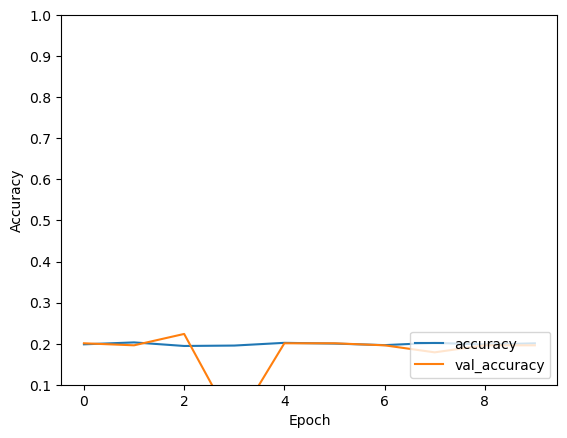

In [23]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_val,  Y_val, verbose=2)

print(test_acc)

In [24]:
y_pred_cnn_p = model.predict(X_val)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

 51/134 [==========>...................] - ETA: 0s

2023-01-08 02:08:02.172911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 0s 3ms/step
Prediction example:  [-4.0383862e+08 -4.0247334e+08 -4.0247264e+08 -4.0279498e+08
 -4.0247440e+08]  Class:  2


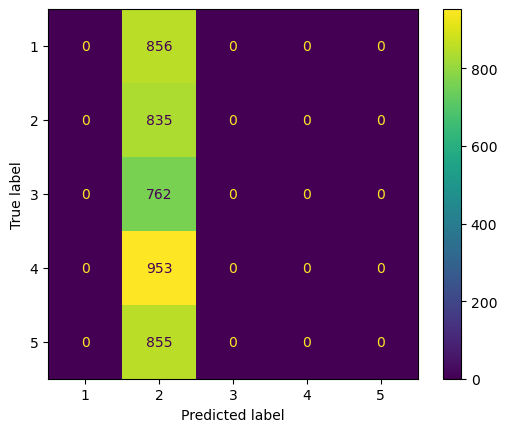

Accuracy Simple Deep Learning model:  0.19596338887585074


In [25]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)